# Linear Regression with Gradient Descent (California Housing Dataset) - Vectorization and Multiple Features 

In [2]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import pandas as pd
import math
import matplotlib.pyplot as plt
import copy, math
import matplotlib.colors as mcolors
from sklearn.metrics import mean_squared_error, r2_score

## 1. Introduction
This notebook implements a multivariate Linear Regression model using vectorized operations for efficiency. It covers data loading, initial feature selection, feature scaling (normalization), vectorized computation of cost and gradient, and the Gradient Descent algorithm for parameter optimization. 

In [4]:
# --- Data Loading and Initial Preparation ---
# Load the California Housing dataset. This dataset is suitable for regression tasks.
housing = fetch_california_housing()
# Create a Pandas DataFrame from the features, using the feature names for columns.
california_df = pd.DataFrame(housing.data, columns=housing.feature_names)
# Add the target variable (Median House Value) to the DataFrame.
california_df['MedHouseVal'] = housing.target

In [5]:
california_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


## 2. Data Exploration

The California Housing dataset contains information about housing prices in California districts. Each row represents a census block group, and the columns describe various attributes of that region. We will explore the relationship between the features and the target variable, Median House Value ('MedHouseVal'), to determine which features are most relevant for predicting house prices.

The 'MedInc' feature represents the median income in each block group, measured in tens of thousands of dollars. We expect that 'MedInc' will have a positive correlation with 'MedHouseVal', as areas with higher median incomes typically have higher property values.

To understand the relationship between the features and the target variable (MedHouseVal), we use a scatter plot matrix. This helps us identify potential linear relationships that are suitable for linear regression.


In [7]:
# Define the initial set of features to be used for the linear regression model.
# These features are chosen to represent key factors influencing house prices.
selected_features = [
    'MedInc',      # Median Income in block group
    'HouseAge',    # Median house age in block group
    'AveRooms',    # Average number of rooms per household
    'Population'   # Block group population
]

In [8]:
# Create the feature matrix (X_train) and target vector (y_train) as NumPy arrays.
# .values converts the Pandas DataFrame/Series to a NumPy array, which is essential
# for vectorized operations.
X_train = california_df[selected_features].values # Array containing the selected features
y_train = california_df['MedHouseVal'].values      # The target variable

#print(f"X_train shape (initial features): {X_train.shape}")
#print(f"y_train shape: {y_train.shape}")



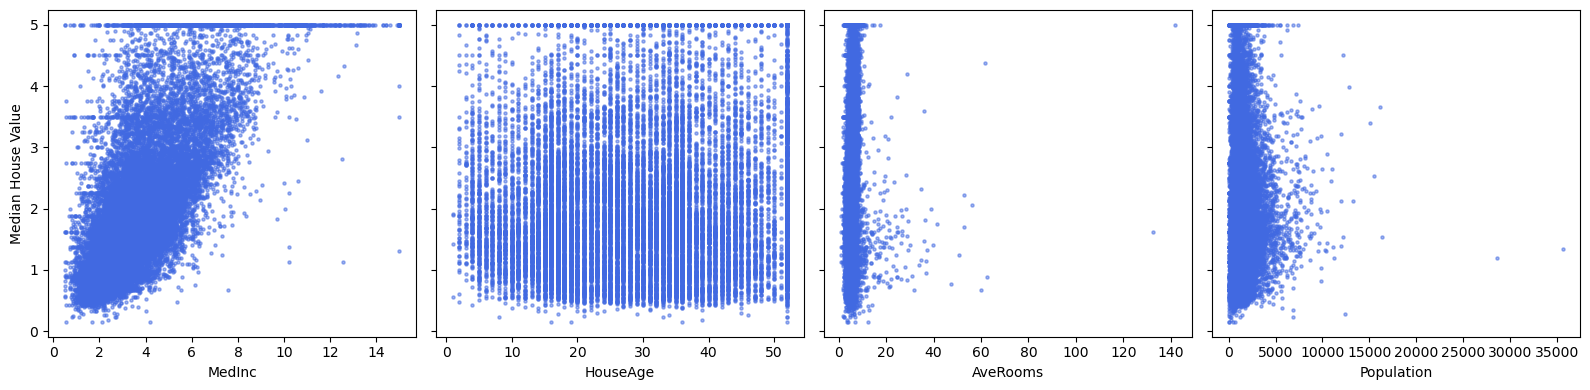

In [9]:
# --- Scatter plot depicting relationships between the variables ---
# X_features should be the list of names that correspond to the columns in X_train
X_features = selected_features

fig,ax=plt.subplots(1, 4, figsize=(16, 4), sharey=True)  
for i in range(len(ax)):
    # Plot each feature against the target
    ax[i].scatter(X_train[:,i], y_train, s=5, alpha=0.5, color = 'royalblue') # Added 's' for marker size, 'alpha' for transparency
    ax[i].set_xlabel(X_features[i])                      # Set x-axis label using the feature name

ax[0].set_ylabel("Median House Value")
plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

## 3. Normalization (Z-score normalization)
Feature scaling (specifically Z-score normalization or Standardization) is critical for Gradient Descent to converge efficiently and effectively, especially when features have different scales, units, or ranges. It helps prevent features with larger values from dominating the cost function.

X_norm shape after normalization: (20640, 4)


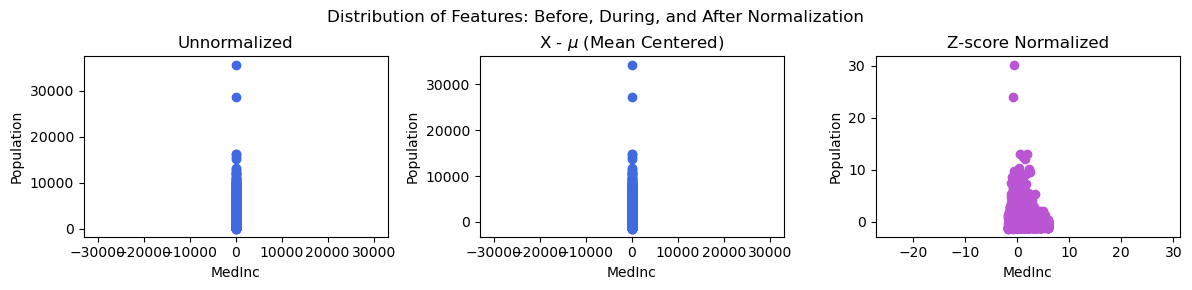

In [11]:
# Normalization 
# Calculate the mean (mu) of each feature (column-wise, axis=0).
mu     = np.mean(X_train,axis=0)
# Calculate the standard deviation (sigma) of each feature (column-wise, axis=0).
sigma  = np.std(X_train,axis=0)
# Handle potential division by zero: if a feature has zero standard deviation (all values are identical),
# replace 0 with a very small number to prevent errors during division.
sigma[sigma == 0] = 1e-10

# Apply Z-score normalization: (x - mean) / standard_deviation.
# This transforms each feature to have a mean of 0 and a standard deviation of 1.
X_norm = (X_train - mu)/sigma

# X_mean is an intermediate step for visualization, showing data centered around zero
# before scaling by standard deviation.
X_mean = (X_train - mu)

print(f"X_norm shape after normalization: {X_norm.shape}")

# --- Normalization Plot ---
# This section visualizes the effect of Z-score normalization on the distribution
# of two selected features. It helps confirm that the data is being scaled
# appropriately for gradient descent.
#print("\n3. Visualizing Feature Normalization...")

# Plotting the relationship between the first and fourth features (MedInc vs Population)
# in their original, mean-centered, and Z-score normalized states.
fig,ax=plt.subplots(1, 3, figsize=(12, 3))

# Subplot 1: Unnormalized data
ax[0].scatter(X_train[:,0], X_train[:,3], color = 'royalblue')
ax[0].set_xlabel(selected_features[0]); ax[0].set_ylabel(selected_features[3]);
ax[0].set_title("Unnormalized")
ax[0].axis('equal') # Ensures equal aspect ratio for visual comparison

# Subplot 2: Mean-centered data (X - mu)
ax[1].scatter(X_mean[:,0], X_mean[:,3], color = 'royalblue')
ax[1].set_xlabel(selected_features[0]); ax[1].set_ylabel(selected_features[3]);
ax[1].set_title(r"X - $\mu$ (Mean Centered)")
ax[1].axis('equal')

# Subplot 3: Z-score normalized data
ax[2].scatter(X_norm[:,0], X_norm[:,3], color = 'mediumorchid')
ax[2].set_xlabel(selected_features[0]); ax[2].set_ylabel(selected_features[3]);
ax[2].set_title(r"Z-score Normalized")
ax[2].axis('equal')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjusts subplot parameters for a tight layout with a main title
fig.suptitle("Distribution of Features: Before, During, and After Normalization")
plt.show()

In [12]:
# --- Vectorized Cost Function ---
# This function calculates the Mean Squared Error (MSE) cost, a common metric for
# regression problems. It uses vectorized NumPy operations for high efficiency.
def compute_cost_vectorized(X, y, w, b):
    """
    Computes the cost (Mean Squared Error) for linear regression using a vectorized approach.
    This function calculates the cost for all examples simultaneously, leveraging NumPy's
    efficient array operations, which is significantly faster than using explicit loops.

    Args:
      X (ndarray (m,n)): Data, where m is the number of examples and n is the number of features.
      y (ndarray (m,)) : Target values corresponding to each example.
      w (ndarray (n,)) : Model parameters (weights) for each feature.
      b (scalar)       : Model parameter (bias term/y-intercept).

    Returns:
      cost (scalar): The computed cost (J) value.
    """
    m = X.shape[0] # Number of training examples

    # Calculate predictions (f_wb) for all examples simultaneously.
    # X (m,n) @ w (n,) performs matrix-vector multiplication, resulting in a vector of shape (m,).
    # 'b' (scalar) is then broadcast across this entire vector.
    f_wb = X @ w + b

    # Calculate the squared error for all examples.
    # (f_wb - y) results in a vector of errors (shape m,), then element-wise squaring.
    squared_error = (f_wb - y)**2

    # Sum all squared errors and apply the cost function formula (1/2m * sum(error^2)).
    cost = np.sum(squared_error) / (2 * m)

    return cost


# --- Vectorized Gradient Function ---
# This function calculates the gradients of the cost function with respect to
# the model parameters (weights 'w' and bias 'b'). These gradients indicate
# the direction and magnitude of the steepest ascent of the cost function,
# which Gradient Descent uses to move towards the minimum.
def compute_gradient_vectorized(X, y, w, b):
    """
    Computes the gradient of the cost function with respect to the parameters w and b,
    using a vectorized approach. This method is much more efficient than using nested loops,
    especially for datasets with many examples or features.

    Args:
      X (ndarray (m,n)): Data, where m is the number of examples and n is the number of features.
      y (ndarray (m,)) : Target values corresponding to each example.
      w (ndarray (n,)) : Model parameters (weights) for each feature.
      b (scalar)       : Model parameter (bias term/y-intercept).

    Returns:
      dj_db (scalar):      The gradient of the cost with respect to the bias term 'b'.
      dj_dw (ndarray (n,)): The gradient of the cost with respect to the weights 'w'.
    """
    m, n = X.shape # Get number of training examples (m) and features (n)

    # Calculate predictions (f_wb) for all examples.
    f_wb = X @ w + b

    # Calculate the error for all examples (prediction - actual target).
    # This results in a vector of errors (shape m,).
    err = f_wb - y

    # Calculate dj_db (gradient with respect to b).
    # This is the sum of all errors, divided by m.
    dj_db = np.sum(err) / m

    # Calculate dj_dw (gradient with respect to w).
    # This is achieved by multiplying the transpose of the feature matrix (X.T)
    # with the error vector, then dividing by m.
    # X.T (n,m) @ err (m,) results in a vector of shape (n,),
    # which is the correct shape for dj_dw (one gradient component per feature).
    dj_dw = (X.T @ err) / m

    return dj_db, dj_dw


# --- Gradient Descent Function ---
# This function implements the batch Gradient Descent algorithm, an iterative optimization
# algorithm used to find the set of model parameters (w and b) that minimize the cost function.
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    """
    Performs batch gradient descent to learn optimal parameters w and b.
    It updates w and b by taking 'num_iters' steps down the gradient,
    using the specified learning rate 'alpha'.

    Args:
      X (ndarray (m,n)): Data, m examples with n features.
      y (ndarray (m,)) : Target values.
      w_in (ndarray (n,)): Initial model parameters (weights).
      b_in (scalar)      : Initial model parameter (bias term).
      cost_function      : A function (e.g., compute_cost_vectorized) to compute the cost.
      gradient_function  : A function (e.g., compute_gradient_vectorized) to compute the gradient.
      alpha (float)      : Learning rate, controls the size of the steps taken down the gradient.
      num_iters (int)    : Number of iterations (gradient steps) to run.

    Returns:
      w (ndarray (n,)) : Updated (learned) values of the model parameters (weights).
      b (scalar)       : Updated (learned) value of the model parameter (bias term).
      J_history (list):  A list containing the cost (J) at each iteration,
                         useful for monitoring convergence.
    """
    # J_history stores the cost at each iteration, used for plotting convergence.
    J_history = []
    # Create deep copies of initial parameters to avoid modifying global variables.
    w = copy.deepcopy(w_in)
    b = b_in

    for i in range(num_iters):
        # Calculate the gradient (dj_db, dj_dw) for the current w and b using the provided gradient function.
        dj_db, dj_dw = gradient_function(X, y, w, b)

        # Update Parameters (w and b) using the gradient descent update rule:
        # parameter = parameter - learning_rate * gradient_of_parameter
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save the cost J at each iteration. This conditional prevents excessive memory use
        # if 'num_iters' is very large, though for 1000 iterations it's not strictly necessary.
        if i < 100000:
            J_history.append(cost_function(X, y, w, b))

        # Print the cost every 1/10th of the total iterations to monitor progress.
        # math.ceil ensures at least one print if num_iters is very small.
        if i % math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}")

    return w, b, J_history # Return the final learned parameters and the cost history


# --- Initialize Parameters for Gradient Descent ---
n_features = X_norm.shape[1] # Get the number of features from the normalized data
w_in = np.zeros(n_features)  # w must be an array of zeros with 'n_features' elements
b_in = 0

# --- Run Gradient Descent with Vectorized Functions ---
# Use the vectorized versions of the cost and gradient functions
w_norm, b_norm, hist = gradient_descent(X_norm, y_train, w_in, b_in,
                                        compute_cost_vectorized,
                                        compute_gradient_vectorized,
                                        1.0e-1, 1000)

print(f"\nFinal w found by gradient descent: {w_norm}")
print(f"Final b found by gradient descent: {b_norm}")

Iteration    0: Cost     2.33
Iteration  100: Cost     0.32
Iteration  200: Cost     0.32
Iteration  300: Cost     0.32
Iteration  400: Cost     0.32
Iteration  500: Cost     0.32
Iteration  600: Cost     0.32
Iteration  700: Cost     0.32
Iteration  800: Cost     0.32
Iteration  900: Cost     0.32

Final w found by gradient descent: [ 0.84093664  0.22058094 -0.06371187  0.02823568]
Final b found by gradient descent: 2.0685581690891452


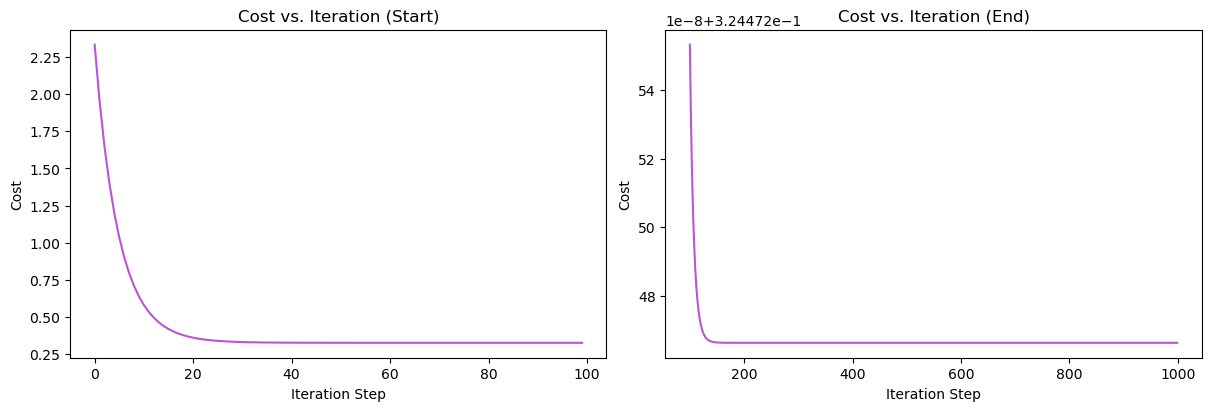

In [13]:
# --- Plot cost versus iteration - Cost should always decrease in successful runs ---
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

# Plot the beginning (first 100 iterations, indices 0-99)
ax1.plot(hist[:100], color = 'mediumorchid')
ax1.set_title("Cost vs. Iteration (Start)");
ax1.set_ylabel('Cost');
ax1.set_xlabel('Iteration Step');

# Plot the rest of the iterations (from iteration 100 to the end)
# The data for ax2 starts from index 100 of 'hist'
start_index_for_end_plot = 100
ax2.plot(start_index_for_end_plot + np.arange(len(hist[start_index_for_end_plot:])), hist[start_index_for_end_plot:], color = 'mediumorchid')
ax2.set_title("Cost vs. Iteration (End)")
ax2.set_ylabel('Cost')
ax2.set_xlabel('Iteration Step')

plt.show()

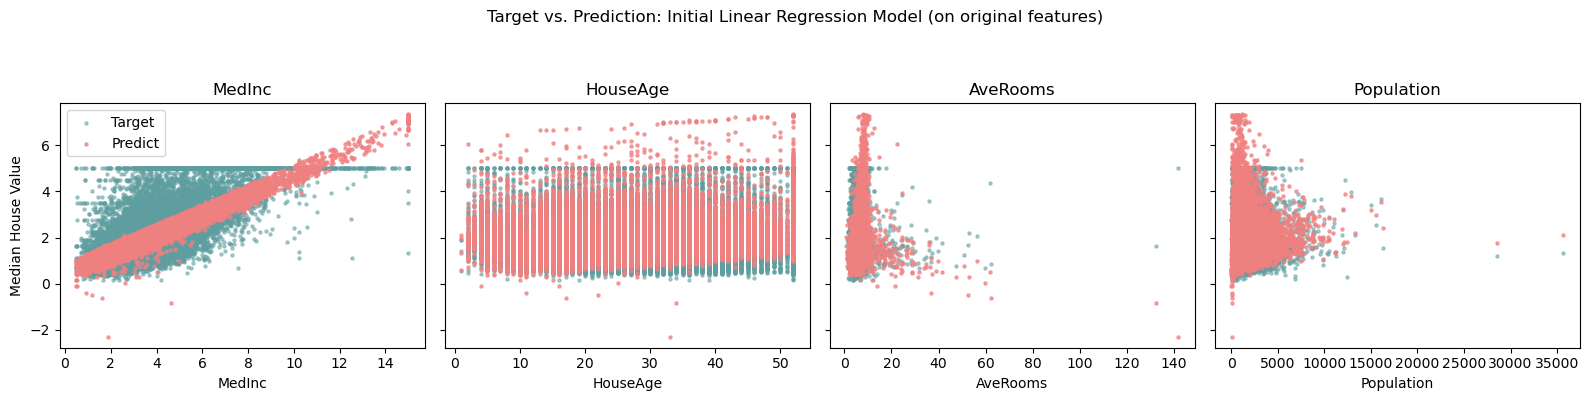

In [14]:
# --- Target Prediction ---
# Define custom colors for this plot
TARGET_COLOR_LR_INITIAL = 'cadetblue' # A muted blue/gray for target points
PREDICT_COLOR_LR_INITIAL = 'lightcoral' # A soft red/coral for prediction points

m = X_norm.shape[0] # Get the number of examples in the normalized dataset (X_norm)
yp = np.zeros(m)    # Initialize an array to store the predicted target values (yp = y_predicted)

# Iterate through each training example to calculate its prediction individually.
# This loop performs the dot product of the example's features with the learned weights (w_norm)
# and adds the bias term (b_norm) for each row.
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_norm) + b_norm

# Create a scatter plot showing the target vs prediction
fig,ax=plt.subplots(1,4,figsize=(16, 4),sharey=True) # Create a figure with 4 subplots (1 row, 4 columns)
                                                  # sharey=True ensures all subplots share the same y-axis scale.

# Loop through each of the selected features to create a scatter plot in its respective subplot.
for i in range(len(ax)):
    # Plot the actual target values (y_train) against the original feature data (X_train[:,i]).
    ax[i].scatter(X_train[:,i],y_train,
                  label = 'Target',     # Label for the legend
                  s=5,                  # Marker size
                  alpha=0.5,            # Transparency (0.5 makes overlapping points darker)
                  color=TARGET_COLOR_LR_INITIAL) # Custom color for target points

    ax[i].set_xlabel(X_features[i]) # Set the x-axis label using the corresponding feature name.

    # Plot the model's predictions (yp) against the same original feature data (X_train[:,i]).
    ax[i].scatter(X_train[:,i],yp,
                  label = 'Predict',    # Label for the legend
                  s=5,                  # Marker size
                  alpha=0.7,            # Slightly less transparent to stand out
                  color=PREDICT_COLOR_LR_INITIAL) # Custom color for prediction points

    ax[i].set_title(X_features[i]) # Set the subplot title to the name of the feature being plotted.

ax[0].set_ylabel("Median House Value"); # Set the common y-axis label for the first subplot.
ax[0].legend(); # Display the legend on the first subplot (it applies to all due to sharey=True).
fig.suptitle("Target vs. Prediction: Initial Linear Regression Model (on original features)", y=1.02) # Main title for the entire figure.
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust subplot parameters for a tight layout, leaving space for the suptitle.
plt.show()

Predictions generated for 20640 examples using vectorized approach.


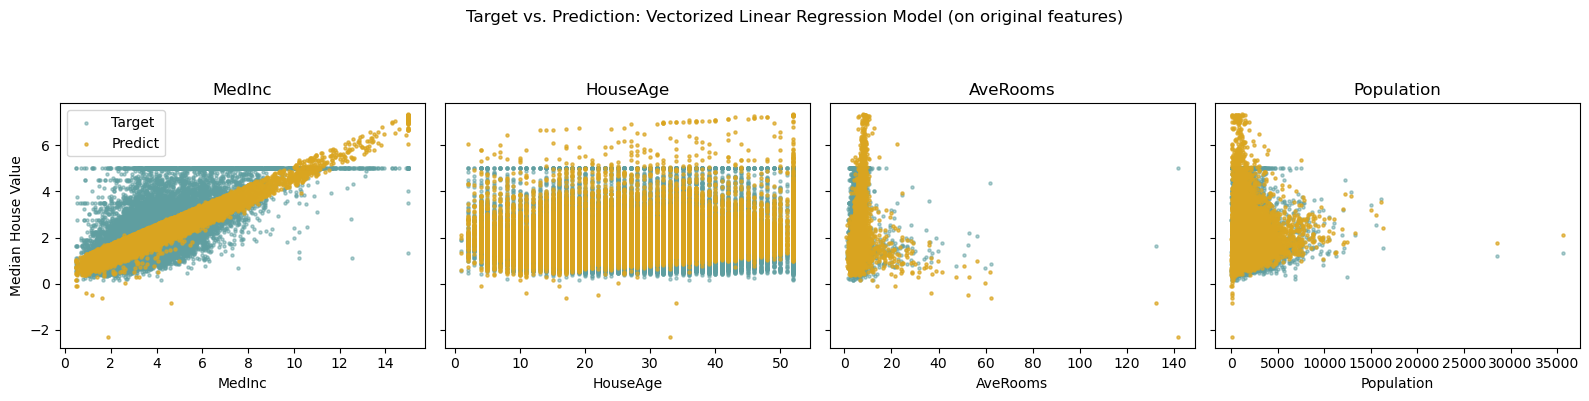

In [15]:
# --- Vectorized Prediction --- 
# Predict target values (yp) using the normalized features (X_norm),
# the learned weights (w_norm), and the bias term (b_norm).
# X_norm (m,n) @ w_norm (n,) performs matrix-vector multiplication resulting in a (m,) vector.
# 'b_norm' (scalar) is broadcast across this vector.
yp = X_norm @ w_norm + b_norm # Fully vectorized prediction!

print(f"Predictions generated for {len(yp)} examples using vectorized approach.")


# --- Plot predictions and targets versus original features (Vectorized LR Model) ---
# This plot visually assesses the performance of the trained Linear Regression model after
# vectorization. It compares the model's predicted values ('yp') against the actual target
# values ('y_train') for each of the original features. Plotting against X_train (original features)
# helps in interpreting the model's fit on the natural scale of the data.
#print("Plotting Vectorized Linear Regression predictions...")

# Define custom colors for this plot. These colors aim to provide clear distinction
# between actuals and predictions, and can be compared to previous plots.
TARGET_COLOR_LR_VECTORIZED = 'cadetblue' # Consistent blue/gray for target points
PREDICT_COLOR_LR_VECTORIZED = 'goldenrod' # A distinct, warm color for predictions

fig,ax=plt.subplots(1,4,figsize=(16, 4),sharey=True) # Create a figure with 4 subplots

# Loop through each of the selected features to generate a scatter plot in its subplot.
for i in range(len(ax)):
    # Plot the actual target values (y_train) against the original feature data.
    ax[i].scatter(X_train[:,i],y_train,
                  label = 'Target',
                  s=5,
                  alpha=0.5,
                  color=TARGET_COLOR_LR_VECTORIZED)

    ax[i].set_xlabel(X_features[i]) # Set x-axis label.

    # Plot the model's predictions (yp) against the same original feature data.
    ax[i].scatter(X_train[:,i],yp,
                  label = 'Predict',
                  s=5,
                  alpha=0.7,
                  color=PREDICT_COLOR_LR_VECTORIZED) # Apply custom color for predictions
    ax[i].set_title(X_features[i]) # Set subplot title.

ax[0].set_ylabel("Median House Value"); # Set common y-axis label for the first subplot.
ax[0].legend(); # Display legend on the first subplot.
fig.suptitle("Target vs. Prediction: Vectorized Linear Regression Model (on original features)", y=1.02) # Main title for the figure.
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for better spacing.
plt.show()


### 3.1 Observation: 
While vectorization significantly improved the *computational efficiency* of the linear regression model, the visual predictions (especially for 'MedInc') still show clear limitations. The linear model inherently struggles to capture highly non-linear relationships and varying data dispersion (heteroscedasticity), often resulting in a somewhat narrow prediction band that doesn't fully cover the true spread of target values. This indicates that a simple linear model, even with optimized implementation, might not be the best fit for all underlying patterns in the dataset.

### Next Steps: 
To address these remaining limitations and further improve predictive accuracy,
the analysis will proceed with:
- 1. Further Feature Engineering: By adding polynomial transformations, logarithmic transforms,
   and interaction terms, we aim to allow the linear model to better approximate complex
   relationships by transforming the input features.
- 2. Exploring More Flexible Models: We will then investigate the performance of non-linear
   models like Random Forest Regressors, which can inherently handle such complexities
   and feature interactions without explicit manual engineering for every non-linearity.

## 4. Feature Engineering - Improving the model by adding a polynomial feature 

The initial Linear Regression model, while efficient due to vectorization, revealed some limitations in its ability to capture all underlying patterns in the data. Specifically, the visual analysis of predictions (e.g., for 'MedInc') showed that the linear model struggled with non-linear relationships and varying data dispersion.

To overcome these limitations and enable the inherently linear model to capture more complex patterns, we employ Feature Engineering. This crucial process involves transforming existing features or creating new ones from the raw data. By doing so, we can:

- Approximate Non-Linearity: Introduce polynomial terms (e.g., $x^{2}$) to allow the linear model to fit curves.
- Handle Skewed Distributions: Apply transformations like logarithmic scaling (e.g., $log(x)$) to make skewed features more symmetrical and their relationships more linear-like.
- Capture Interactions: Create new features by combining existing ones (e.g., multiplying two features) to model how the effect of one feature might depend on another.

Through this strategic feature engineering, the linear regression model will be provided with more informative inputs, allowing it to achieve a better fit to the underlying data patterns without changing the model's core linear assumption.

In [18]:
# 1. Redefine X_train and y_train for Model V2
# We re-initialize the feature matrix (X_train_v2) and target (y_train_v2)
# for this iteration. This ensures a clean slate for feature engineering for this model.
# (Assumes 'california_df' is loaded from the start of the notebook)
initial_feature_names = [
    'MedInc',
    'HouseAge',
    'AveRooms',
    'Population'
]
X_train_v2 = california_df[initial_feature_names].values # Create new feature matrix for V2
y_train_v2 = california_df['MedHouseVal'].values         # Target remains the same
X_features_v2 = list(initial_feature_names)              # Mutable list to track features for V2 model

print(f"\nInitial X_train_v2 shape: {X_train_v2.shape}")


Initial X_train_v2 shape: (20640, 4)


Adding 'MedInc_Sq' (Median Income squared) feature...
X_train_v2 shape after adding 'MedInc_Sq': (20640, 5)
Updated feature list for Model V2: ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'MedInc_Sq']

Normalizing features for Model V2 (Z-score normalization)...
X_norm_v2 shape after normalization: (20640, 5)

Running Gradient Descent for Model V2...
Iteration    0: Cost     2.29
Iteration  100: Cost     0.33
Iteration  200: Cost     0.32
Iteration  300: Cost     0.32
Iteration  400: Cost     0.32
Iteration  500: Cost     0.32
Iteration  600: Cost     0.32
Iteration  700: Cost     0.32
Iteration  800: Cost     0.32
Iteration  900: Cost     0.32

Final w for Model V2: [ 1.12809146  0.22966625 -0.06748978  0.02359325 -0.30283916]
Final b for Model V2: 2.0685581690891452

Plotting Cost vs. Iteration for Model V2...


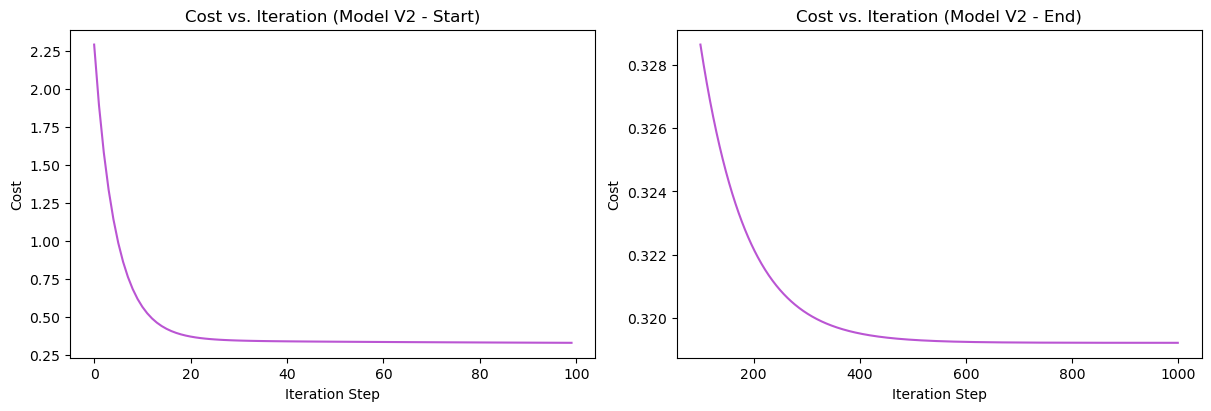

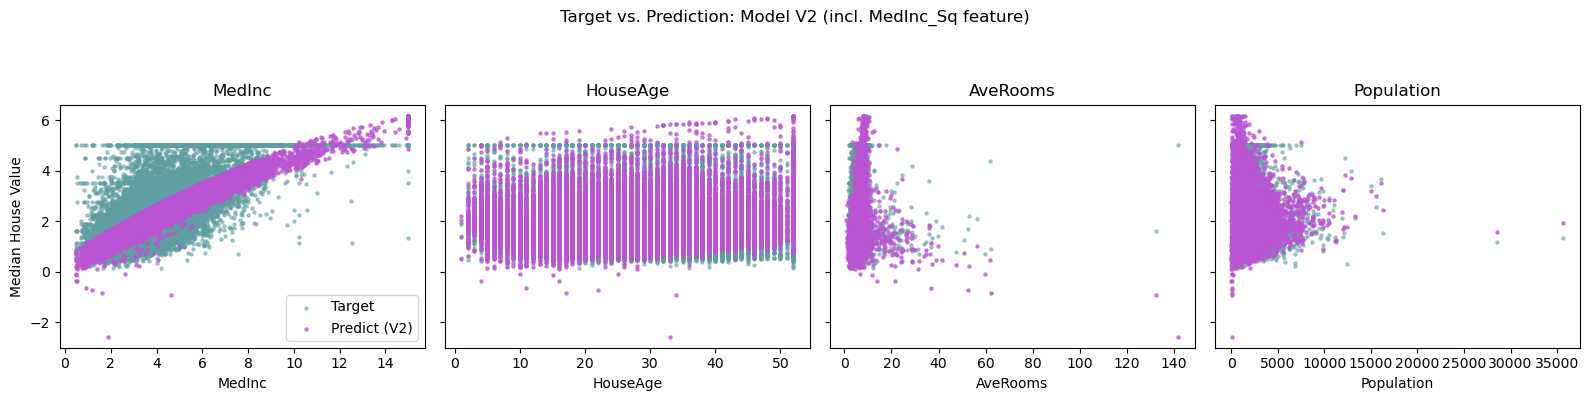

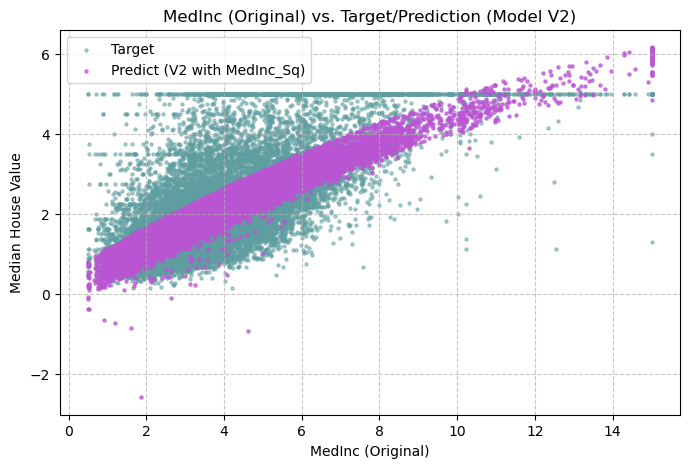


--- End of Iteration 2 Analysis ---


In [19]:
# 2. Add Polynomial Feature for 'MedInc' to X_train_v2
print("Adding 'MedInc_Sq' (Median Income squared) feature...")
# Rationale: This polynomial term aims to help the linear model better capture
# the observed non-linear (curved) relationship of 'MedInc' with the target.
medinc_original_column_index_v2 = X_features_v2.index('MedInc')
medinc_column_data_v2 = X_train_v2[:, medinc_original_column_index_v2]
medinc_squared_data_v2 = medinc_column_data_v2**2

X_features_v2.append('MedInc_Sq') # Add the new feature's name to our tracking list
X_train_v2 = np.c_[X_train_v2, medinc_squared_data_v2] # Concatenate the new squared feature as a new column

print(f"X_train_v2 shape after adding 'MedInc_Sq': {X_train_v2.shape}")
print(f"Updated feature list for Model V2: {X_features_v2}")


# 3. Normalize the NEW X_train_v2 (with the added feature)
# Normalization (Z-score scaling) is performed again on the expanded feature set.
# This is crucial because adding new features changes the overall scale and distribution,
# and Gradient Descent requires features to be on a similar scale for efficient convergence.
print("\nNormalizing features for Model V2 (Z-score normalization)...")
mu_v2     = np.mean(X_train_v2, axis=0)  # Calculate mean for each feature in the new X_train_v2
sigma_v2  = np.std(X_train_v2, axis=0)   # Calculate standard deviation for each feature
sigma_v2[sigma_v2 == 0] = 1e-10          # Handle potential division by zero

X_norm_v2 = (X_train_v2 - mu_v2) / sigma_v2 # Apply Z-score normalization

print(f"X_norm_v2 shape after normalization: {X_norm_v2.shape}")


# 4. Run Gradient Descent with the new X_norm_v2
# The Gradient Descent algorithm is now executed with the expanded and normalized
# feature set (X_norm_v2). This trains "Model V2" to find optimal weights (w_final_v2)
# and bias (b_final_v2) that incorporate the new polynomial feature.
print("\nRunning Gradient Descent for Model V2...")
n_features_v2 = X_norm_v2.shape[1] # Get the total number of features (now 5)
w_in_v2 = np.zeros(n_features_v2)  # Initialize weights as zeros for the 5 features
b_in_v2 = 0                        # Initialize bias as zero

alpha_v2 = 1.0e-1 # Learning rate
num_iters_v2 = 1000 # Number of iterations

# Call the gradient_descent function using the updated data and initial parameters.
# (compute_cost_vectorized and compute_gradient_vectorized functions are defined earlier)
w_final_v2, b_final_v2, hist_v2 = gradient_descent(X_norm_v2, y_train_v2, w_in_v2, b_in_v2,
                                                compute_cost_vectorized,
                                                compute_gradient_vectorized,
                                                alpha_v2, num_iters_v2)

print(f"\nFinal w for Model V2: {w_final_v2}")
print(f"Final b for Model V2: {b_final_v2}")


# 5. Plot Cost History for Model V2
# This plot visualizes the convergence of the cost function for Model V2 over iterations.
# A continuously decreasing cost indicates successful learning.
print("\nPlotting Cost vs. Iteration for Model V2...")
fig, (ax1_v2, ax2_v2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1_v2.plot(hist_v2[:100], color = 'mediumorchid') # Plot first 100 iterations (start of convergence)
ax1_v2.set_title("Cost vs. Iteration (Model V2 - Start)");
ax1_v2.set_ylabel('Cost');
ax1_v2.set_xlabel('Iteration Step');
start_index_for_end_plot_v2 = 100
ax2_v2.plot(start_index_for_end_plot_v2 + np.arange(len(hist_v2[start_index_for_end_plot_v2:])), hist_v2[start_index_for_end_plot_v2:], color = 'mediumorchid')
ax2_v2.set_title("Cost vs. Iteration (Model V2 - End)") # Plot remaining iterations (end of convergence)
ax2_v2.set_ylabel('Cost')
ax2_v2.set_xlabel('Iteration Step')
plt.show()


# 6. Predict and Plot with Final Model V2
# This section generates predictions using the trained Model V2 and visualizes its performance
# against the original features. This helps assess if the added polynomial feature improved the fit.

# Make predictions using the optimized Model V2 parameters (w_final_v2, b_final_v2)
# and the normalized feature set (X_norm_v2).
#print("\nGenerating predictions and plotting for Model V2...")

yp_final_v2 = X_norm_v2 @ w_final_v2 + b_final_v2 # Vectorized prediction for Model V2

# Define custom colors for Model V2 plots. These are distinct from initial LR plots
# and prepare for comparison with Random Forest.
TARGET_COLOR_V2 = 'cadetblue'         # Consistent target color
PREDICT_COLOR_V2 = 'mediumorchid'     # New color for Model V2 predictions (suggests improvement)

# Plotting the initial 4 features vs predictions from Model V2.
# We use 'initial_feature_names' for the x-axis to maintain visual consistency
# with previous plots, allowing for direct comparison of prediction patterns.
fig,ax=plt.subplots(1,len(initial_feature_names),figsize=(16, 4),sharey=True)
for i in range(len(initial_feature_names)):
    ax[i].scatter(X_train_v2[:,i],y_train_v2,
                  label = 'Target', s=5, alpha=0.5, color=TARGET_COLOR_V2) # Apply target color
    ax[i].scatter(X_train_v2[:,i],yp_final_v2,
                  label = 'Predict (V2)', s=5, alpha=0.7, color=PREDICT_COLOR_V2) # Apply prediction color
    ax[i].set_xlabel(initial_feature_names[i])
    ax[i].set_title(initial_feature_names[i])

ax[0].set_ylabel("Median House Value");
ax[0].legend();
fig.suptitle("Target vs. Prediction: Model V2 (incl. MedInc_Sq feature)", y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Additional Plot: Explicitly plot MedInc (original) vs. predictions for Model V2 ---
# This plot is crucial to visually confirm if the added polynomial term helped capture
# the non-linear relationship in 'MedInc' more effectively than the initial linear model.
plt.figure(figsize=(8, 5))
plt.scatter(X_train_v2[:, medinc_original_column_index_v2], y_train_v2,
            label='Target', s=5, alpha=0.5, color=TARGET_COLOR_V2)
plt.scatter(X_train_v2[:, medinc_original_column_index_v2], yp_final_v2,
            label='Predict (V2 with MedInc_Sq)', s=5, alpha=0.7, color=PREDICT_COLOR_V2)
plt.xlabel("MedInc (Original)")
plt.ylabel("Median House Value")
plt.title(f"MedInc (Original) vs. Target/Prediction (Model V2)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\n--- End of Iteration 2 Analysis ---")

## 5. Further Feature Engineering - Log Transformation

Building on the previous efforts to capture non-linearity with polynomial terms, we now introduce **logarithmic transformations**. This is a particularly powerful technique for handling numerical features with specific distributional characteristics:

- Addressing Skewed Distributions: Many real-world features, such as income, population counts, or asset values, often exhibit highly skewed distributions (e.g., a long tail to the right, where most values are concentrated at the lower end but a few outliers are extremely large). Linear models generally perform better when features are more symmetrically distributed (closer to a Gaussian or normal distribution). A logarithmic transformation effectively compresses the larger values and stretches out the smaller values, thereby making the distribution more symmetrical and manageable for the model.

- Capturing Diminishing Returns: Logarithmic transforms are also excellent for modeling relationships where the impact of a feature on the target variable shows diminishing returns. For instance, an initial increase in median income might have a substantial impact on house value, but successive equivalent increases at already very high income levels might lead to a relatively smaller additional effect. A linear model applied to a logarithmically transformed feature can effectively capture this type of non-linear relationship.

- Converting Multiplicative to Additive Relationships: In some cases, a multiplicative relationship between a feature and the target can become additive after a log transformation, making it more amenable to a linear model.

In this analysis, features like 'Population' are often prime candidates for a logarithmic transformation due to their typically skewed distributions. We frequently use np.log1p(x) (which calculates $log(1+x)$) as it's a robust alternative to np.log(x), safely handling cases where feature values might be zero and preventing errors (as $log(0)$ is undefined).

In [21]:
# 1. Re-initialize X_train with original 4 features (as we did for Model V2)
# Start with the base set of features to ensure a clean and controlled
# application of new feature engineering steps for this iteration (Model V3).
# (Assumes 'california_df' is still loaded from the start of the notebook)
initial_feature_names = [
    'MedInc',
    'HouseAge',
    'AveRooms',
    'Population'
]
X_train_v3 = california_df[initial_feature_names].values # Create a new feature matrix for Model V3
y_train_v3 = california_df['MedHouseVal'].values         # Target variable remains unchanged
X_features_v3 = list(initial_feature_names)              # Mutable list to track all features for Model V3

print(f"\nInitial X_train_v3 shape: {X_train_v3.shape}")


Initial X_train_v3 shape: (20640, 4)


Adding 'MedInc_Sq', 'Log_Population', and 'MedInc_x_AveRooms' features...
X_train_v3 shape after adding all new features: (20640, 7)
Updated feature list for Model V3: ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'MedInc_Sq', 'Log_Population', 'MedInc_x_AveRooms']

Normalizing features for Model V3 (Z-score normalization)...
X_norm_v3 shape after normalization: (20640, 7)

Running Gradient Descent for Model V3 (7 features)...
Iteration    0: Cost     2.26
Iteration  100: Cost     0.33
Iteration  200: Cost     0.32
Iteration  300: Cost     0.32
Iteration  400: Cost     0.32
Iteration  500: Cost     0.32
Iteration  600: Cost     0.32
Iteration  700: Cost     0.32
Iteration  800: Cost     0.32
Iteration  900: Cost     0.32

Final w for Model V3: [ 1.11695028  0.22956061 -0.08867272  0.03605538 -0.32217465 -0.01642545
  0.04144599]
Final b for Model V3: 2.0685581690891452

Plotting Cost vs. Iteration for Model V3...


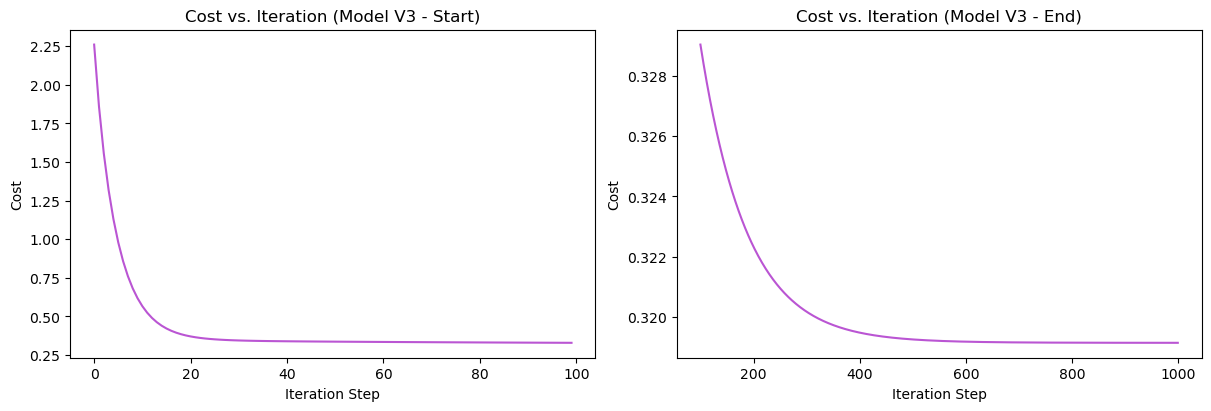

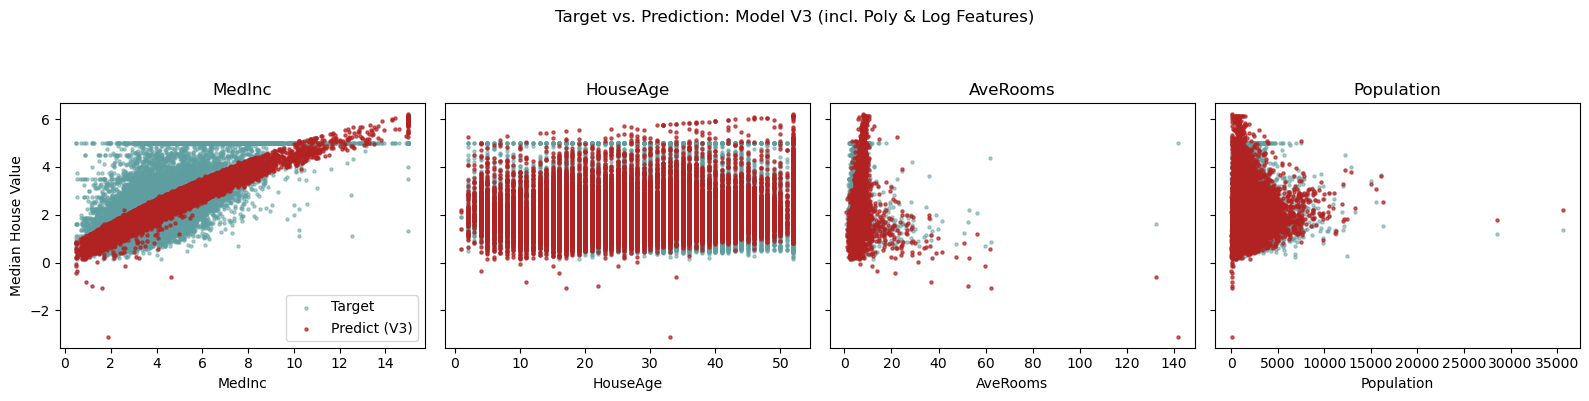

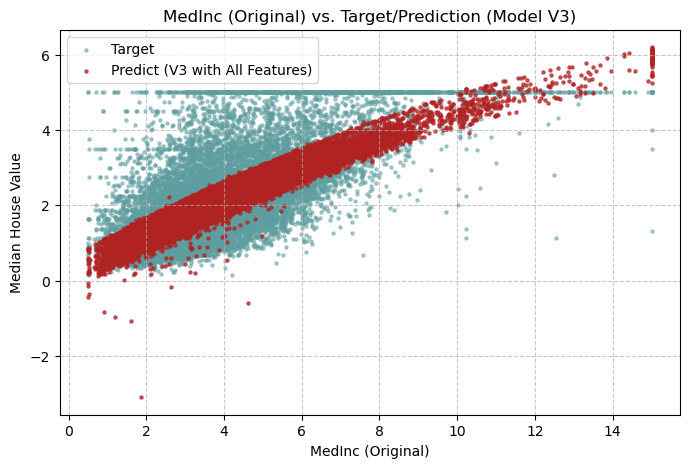

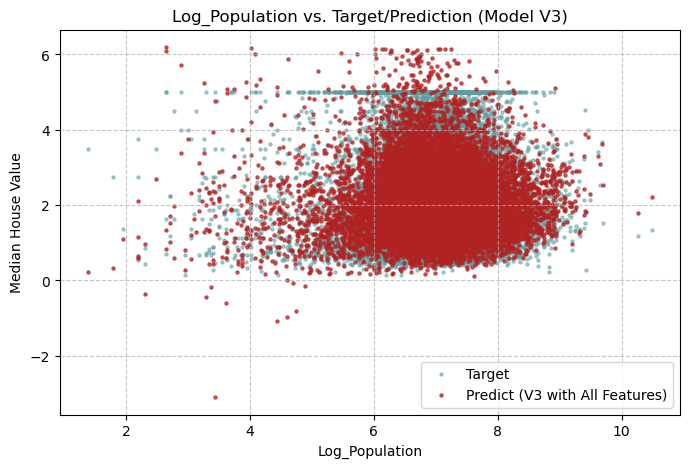


--- End of Iteration 3 Analysis ---


In [22]:
# 2. Add ALL desired Polynomial, Log, and Interaction Features to X_train_v3
print("Adding 'MedInc_Sq', 'Log_Population', and 'MedInc_x_AveRooms' features...")

# --- Feature 2.1: Add MedInc_Sq (Polynomial Feature) ---
# Re-adding the squared term for 'MedInc' to continue capturing its non-linear trend.
medinc_original_column_index_v3 = X_features_v3.index('MedInc') # Get original index of MedInc
medinc_column_data_v3 = X_train_v3[:, medinc_original_column_index_v3]
medinc_squared_data_v3 = medinc_column_data_v3**2
X_features_v3.append('MedInc_Sq') # Add feature name
X_train_v3 = np.c_[X_train_v3, medinc_squared_data_v3] # Concatenate to X_train_v3


# --- Feature 2.2: Add Log_Population (Logarithmic Transformation) ---
# Rationale: 'Population' often has a highly skewed distribution. A logarithmic
# transformation helps to normalize skewed data, making its relationship with the
# target more linear-like and improving model performance. Using `np.log1p` (log(1+x))
# is robust as it handles zero values gracefully.
population_original_column_index_v3 = initial_feature_names.index('Population') # Get original index from base features
population_column_data_v3 = california_df['Population'].values # Use original DataFrame column for robustness
log_population_data_v3 = np.log1p(population_column_data_v3)
X_features_v3.append('Log_Population') # Add feature name
X_train_v3 = np.c_[X_train_v3, log_population_data_v3] # Concatenate to X_train_v3


# --- Feature 2.3: Add MedInc_x_AveRooms (Interaction Term) ---
# Rationale: This feature captures the idea that the effect of 'AveRooms' on house value
# might depend on the 'MedInc' level, or vice-versa. It allows the model to learn
# a more nuanced relationship than if these features were considered only independently.
# It's crucial to use the original, untransformed features for interaction terms.
medinc_x_averooms_data_v3 = california_df['MedInc'].values * california_df['AveRooms'].values
X_features_v3.append('MedInc_x_AveRooms') # Add feature name
X_train_v3 = np.c_[X_train_v3, medinc_x_averooms_data_v3] # Concatenate to X_train_v3

print(f"X_train_v3 shape after adding all new features: {X_train_v3.shape}")
print(f"Updated feature list for Model V3: {X_features_v3}")


# 3. Normalize the NEW X_train_v3 (with all added features)
# After adding new features, it's essential to re-normalize the entire feature matrix.
# This ensures that all features (original and engineered) are on a consistent scale
# (mean 0, standard deviation 1), which is vital for the efficient convergence of Gradient Descent.
print("\nNormalizing features for Model V3 (Z-score normalization)...")
mu_v3     = np.mean(X_train_v3, axis=0)  # Calculate mean for each feature in the expanded X_train_v3
sigma_v3  = np.std(X_train_v3, axis=0)   # Calculate standard deviation for each feature
sigma_v3[sigma_v3 == 0] = 1e-10          # Handle potential division by zero

X_norm_v3 = (X_train_v3 - mu_v3) / sigma_v3 # Apply Z-score normalization

print(f"X_norm_v3 shape after normalization: {X_norm_v3.shape}")


# 4. Run Gradient Descent with the new X_norm_v3
# The Gradient Descent algorithm is executed again to train "Model V3" with the
# now 7-dimensional feature space. It will find the optimal weights and bias
# for this enhanced linear model.
print("\nRunning Gradient Descent for Model V3 (7 features)...")
n_features_v3 = X_norm_v3.shape[1] # Get the total number of features (now 7)
w_in_v3 = np.zeros(n_features_v3)  # Initialize weights as zeros for all 7 features
b_in_v3 = 0                        # Initialize bias as zero

alpha_v3 = 1.0e-1 # Learning rate - might need fine-tuning for new feature sets
num_iters_v3 = 1000 # Number of iterations

# Call the gradient_descent function using the updated data and parameters.
# (compute_cost_vectorized and compute_gradient_vectorized functions are defined earlier)
w_final_v3, b_final_v3, hist_v3 = gradient_descent(X_norm_v3, y_train_v3, w_in_v3, b_in_v3,
                                                compute_cost_vectorized,
                                                compute_gradient_vectorized,
                                                alpha_v3, num_iters_v3)

print(f"\nFinal w for Model V3: {w_final_v3}")
print(f"Final b for Model V3: {b_final_v3}")


# 5. Plot Cost History for Model V3
# This plot visualizes the convergence of the cost function for Model V3.
# A smooth, continuously decreasing curve indicates that Gradient Descent is
# successfully minimizing the cost.
print("\nPlotting Cost vs. Iteration for Model V3...")
fig, (ax1_v3, ax2_v3) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1_v3.plot(hist_v3[:100],  color = 'mediumorchid') # Plot the initial iterations to show rapid decrease
ax1_v3.set_title("Cost vs. Iteration (Model V3 - Start)");
ax1_v3.set_ylabel('Cost');
ax1_v3.set_xlabel('Iteration Step');
start_index_for_end_plot_v3 = 100
ax2_v3.plot(start_index_for_end_plot_v3 + np.arange(len(hist_v3[start_index_for_end_plot_v3:])), hist_v3[start_index_for_end_plot_v3:], color = 'mediumorchid')
ax2_v3.set_title("Cost vs. Iteration (Model V3 - End)") # Plot later iterations to show fine-tuning/convergence
ax2_v3.set_ylabel('Cost')
ax2_v3.set_xlabel('Iteration Step')
plt.show()


# 6. Predict and Plot with Final Model V3
# This section generates predictions using the trained Model V3 and visualizes its
# performance against the original features. This is a critical step to assess
# the impact of the comprehensive feature engineering on the linear model's fit.

#print("\nGenerating predictions and plotting for Model V3...")

# Make predictions using the optimized Model V3 parameters (w_final_v3, b_final_v3)
# and the normalized feature set (X_norm_v3).
yp_final_v3 = X_norm_v3 @ w_final_v3 + b_final_v3 # Vectorized prediction for Model V3

# Define custom colors for Model V3 plots. These are chosen for high contrast
# and to differentiate this model's predictions from previous iterations.
TARGET_COLOR_V3 = 'cadetblue' # Consistent target color (blue/gray)
PREDICT_COLOR_V3 = 'firebrick' # Strong, contrasting red for Model V3 predictions

# Plotting the initial 4 original features vs predictions from Model V3.
# We use 'initial_feature_names' for the x-axis labels to maintain visual consistency
# with previous plots, allowing for direct comparison of prediction patterns.
fig,ax=plt.subplots(1,len(initial_feature_names),figsize=(16, 4),sharey=True)
for i in range(len(initial_feature_names)): # Loop through the original 4 features for plotting
    ax[i].scatter(X_train_v3[:,i],y_train_v3,
                  label = 'Target', s=5, alpha=0.5, color=TARGET_COLOR_V3)
    ax[i].scatter(X_train_v3[:,i],yp_final_v3,
                  label = 'Predict (V3)', s=5, alpha=0.7, color=PREDICT_COLOR_V3)
    ax[i].set_xlabel(initial_feature_names[i])
    ax[i].set_title(initial_feature_names[i])

ax[0].set_ylabel("Median House Value");
ax[0].legend();
fig.suptitle("Target vs. Prediction: Model V3 (incl. Poly & Log Features)", y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Optional: Explicitly plot MedInc (original) vs. predictions for Model V3 ---
# This plot is crucial to visually confirm if the added polynomial and other terms
# helped capture the non-linear relationship in 'MedInc' more effectively.
plt.figure(figsize=(8, 5))
plt.scatter(X_train_v3[:, medinc_original_column_index_v3], y_train_v3,
            label='Target', s=5, alpha=0.5, color=TARGET_COLOR_V3)
plt.scatter(X_train_v3[:, medinc_original_column_index_v3], yp_final_v3,
            label='Predict (V3 with All Features)', s=5, alpha=0.7, color=PREDICT_COLOR_V3)
plt.xlabel("MedInc (Original)")
plt.ylabel("Median House Value")
plt.title(f"MedInc (Original) vs. Target/Prediction (Model V3)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- Additional Plot: Plot the new Log_Population feature if you want to see its effect ---
# This plot visualizes the relationship between the transformed 'Log_Population' feature
# and the target, showing how the model predicts on this new scale.
log_pop_col_idx = X_features_v3.index('Log_Population') # Get the index of the Log_Population feature
plt.figure(figsize=(8, 5))
plt.scatter(X_train_v3[:, log_pop_col_idx], y_train_v3,
            label='Target', s=5, alpha=0.5, color=TARGET_COLOR_V3)
plt.scatter(X_train_v3[:, log_pop_col_idx], yp_final_v3,
            label='Predict (V3 with All Features)', s=5, alpha=0.7, color=PREDICT_COLOR_V3)
plt.xlabel("Log_Population")
plt.ylabel("Median House Value")
plt.title(f"Log_Population vs. Target/Prediction (Model V3)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\n--- End of Iteration 3 Analysis ---")

In [23]:
# Calculate RMSE: Measures the average magnitude of the errors. Lower is better.
rmse_v1 = np.sqrt(mean_squared_error(y_train, yp))
rmse_v2 = np.sqrt(mean_squared_error(y_train_v2, yp_final_v2))
rmse_v3 = np.sqrt(mean_squared_error(y_train_v3, yp_final_v3))

# Calculate R-squared: Represents the proportion of variance in the dependent variable
# that is predictable from the independent variables. Higher (closer to 1) is better.
r2_v1 = r2_score(y_train, yp)
r2_v3 = r2_score(y_train_v3, yp_final_v3)
r2_v2 = r2_score(y_train_v2, yp_final_v2)

print(f"\n--- Performance of the Models (Linear Regression) ---")
print(f" RMSE of Model 1: {rmse_v1:.4f}")
print(f" R-squared of Model 1: {r2_v1:.4f}")
print(f" RMSE of Model 2: {rmse_v2:.4f}")
print(f" R-squared of Model 2: {r2_v2:.4f}")
print(f" RMSE of Model 3: {rmse_v3:.4f}")
print(f" R-squared of Model 3: {r2_v3:.4f}")


--- Performance of the Models (Linear Regression) ---
 RMSE of Model 1: 0.8056
 R-squared of Model 1: 0.5126
 RMSE of Model 2: 0.7990
 R-squared of Model 2: 0.5205
 RMSE of Model 3: 0.7989
 R-squared of Model 3: 0.5206


## 6. Concluding Linear Regression Analysis
Despite extensive feature engineering in Model V3, which included polynomial, logarithmic, and interaction terms, the Linear Regression model still exhibits inherent limitations. The visual analysis, especially for 'MedInc', indicates its struggle with highly non-linear relationships and varying data dispersion (heteroscedasticity). The linear model's fundamental assumption of linearity and homoscedasticity prevents it from fully capturing such complex patterns.

While each iteration of feature engineering led to improvements in the overall fit (as seen by the decreasing cost and improved R-squared values within this notebook), the model's core constraints limit its ultimate predictive power for intricate data structures.

Therefore, to potentially achieve a more accurate and robust model capable of handling these complex, non-linear relationships with ease, the **Random Forest Regressor** can be explored.